Petite démo rapide pour montrer que notre modèle génère bien des images. Vous pouvez plutôt test.py mais si vous préférez le notebook alors voici.

/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


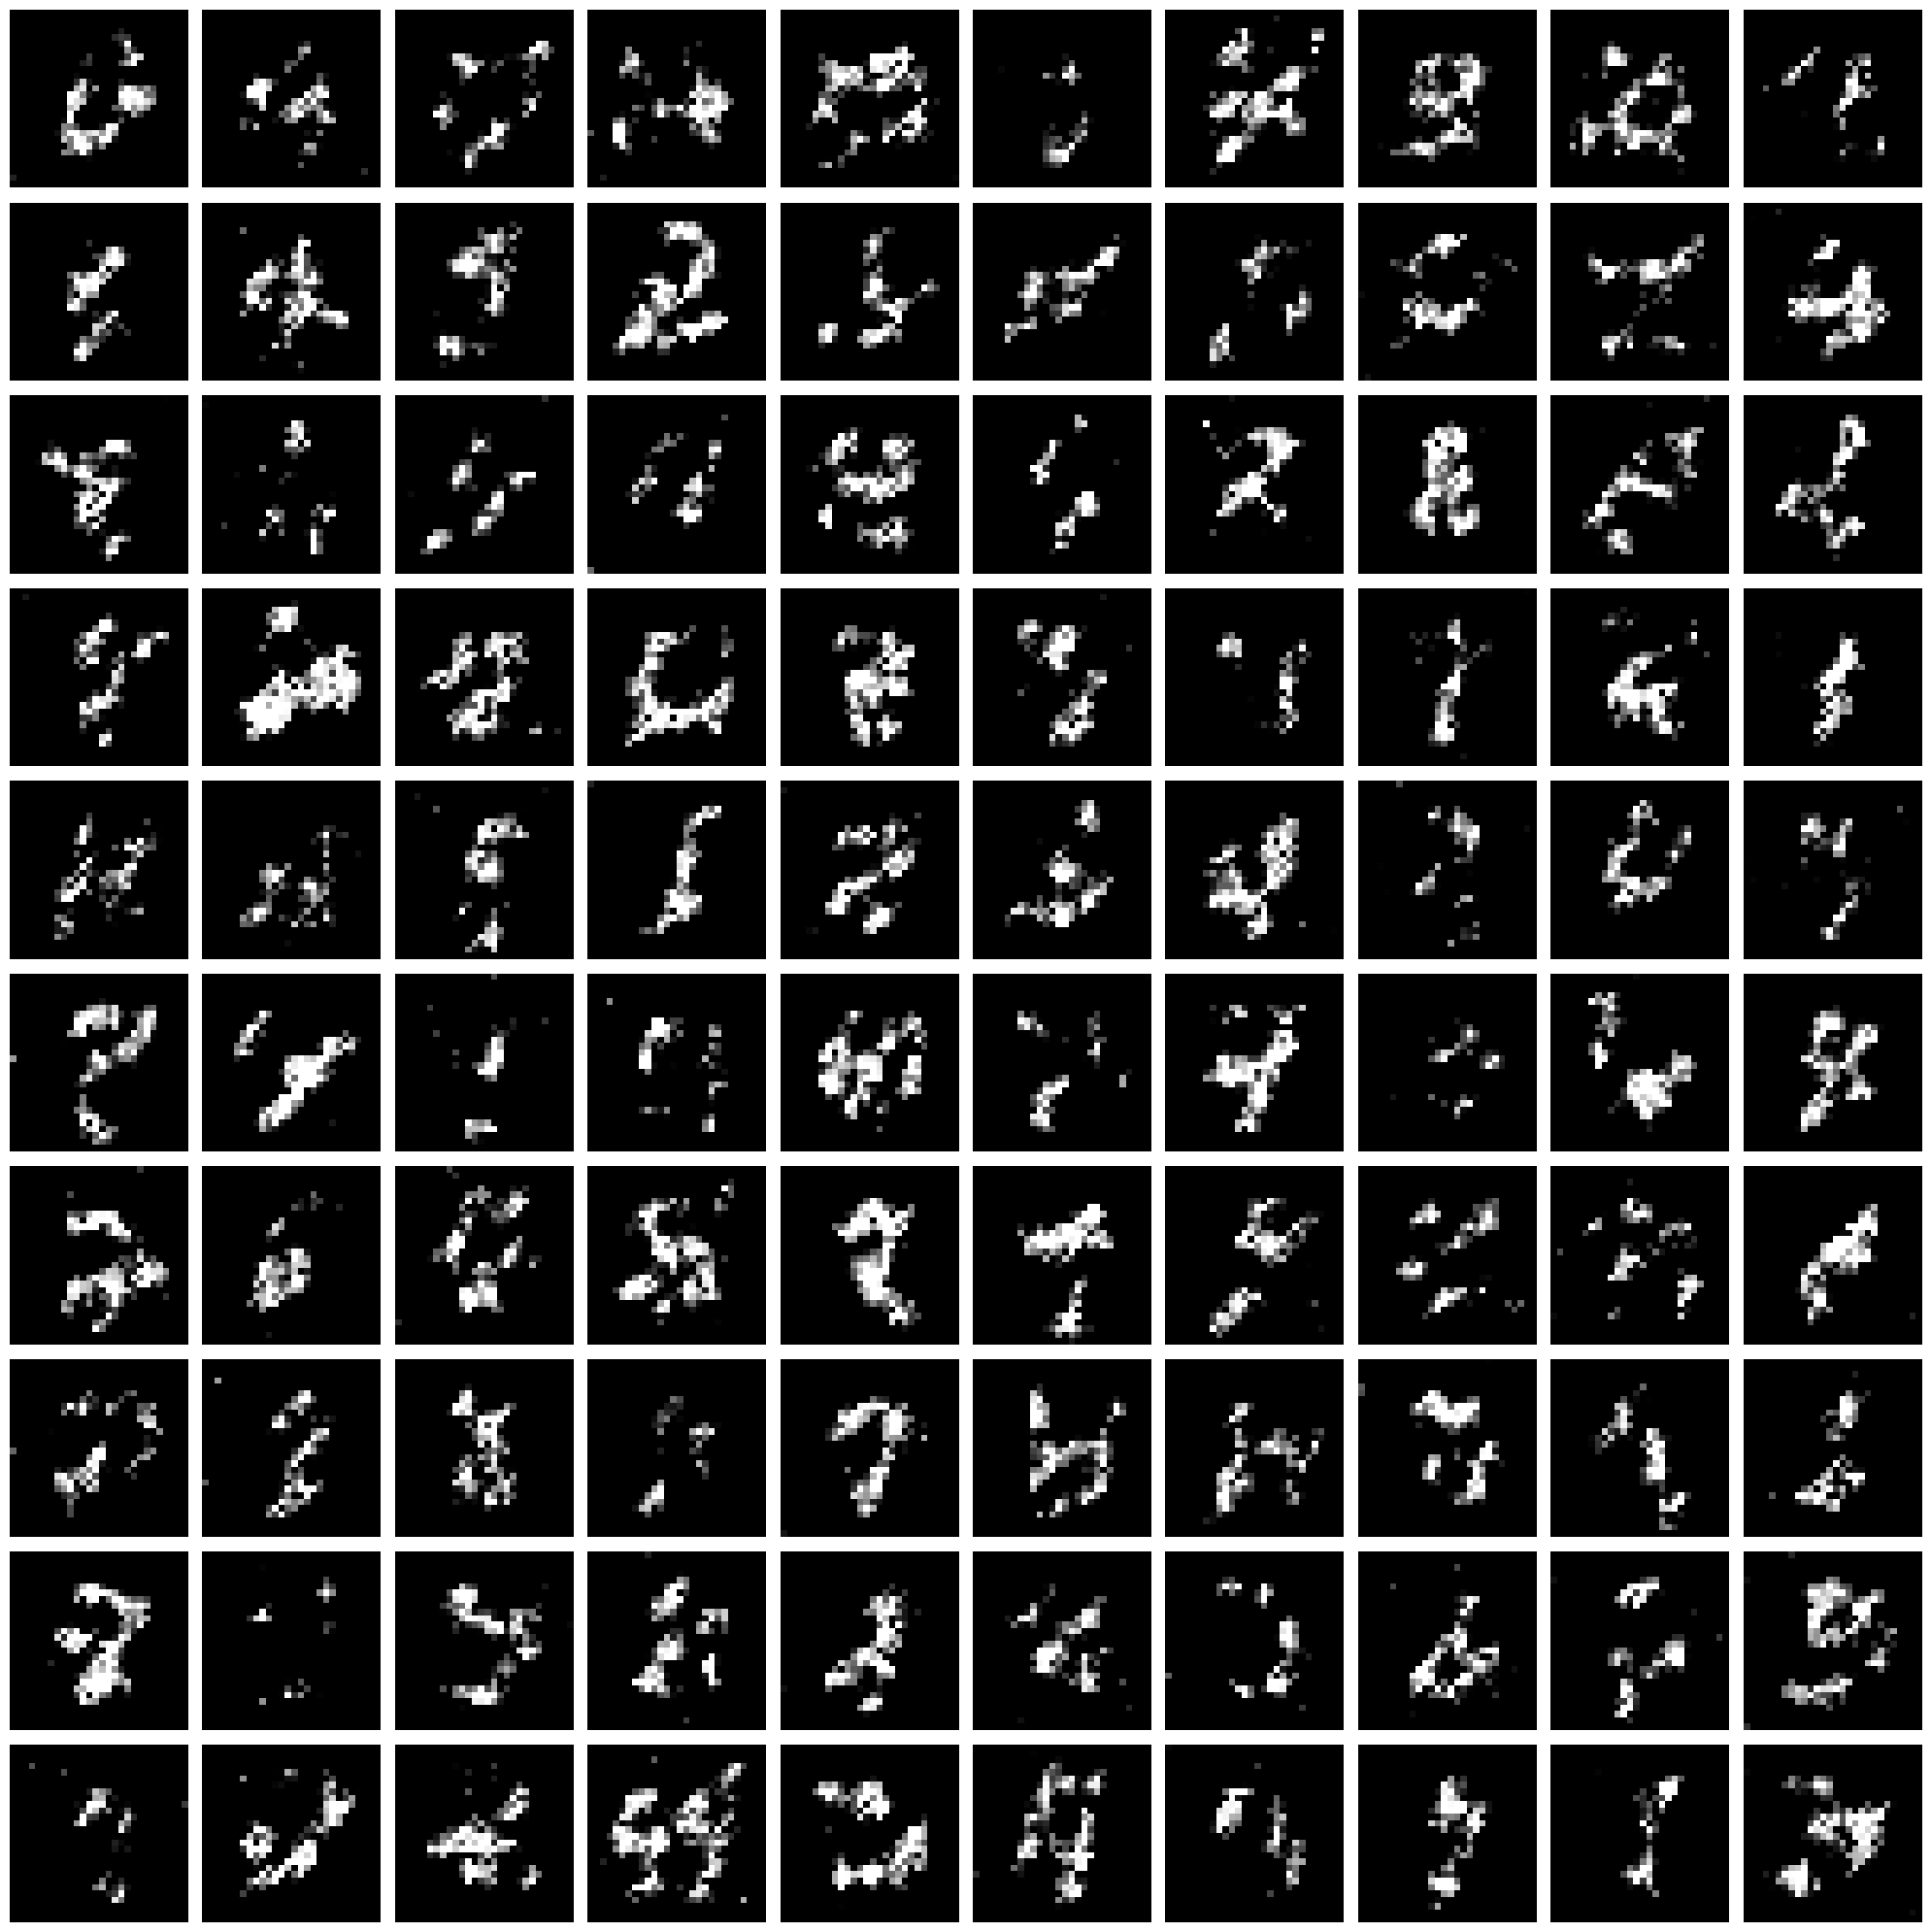

In [1]:
import jax
from jax import numpy as jnp
from flax.training import checkpoints
from flax import nnx
import diffrax 
import unet
import os
import matplotlib.pyplot as plt
import numpy as np


#On commence par restaurer le modèle sauvegardé par train.py
model_dir =  os.path.abspath("./saved_models/V1")
restored_state = checkpoints.restore_checkpoint(model_dir, target=None)

abstract_model = nnx.eval_shape(lambda: unet.UNet(in_channels=1, time_dim=40, rngs=nnx.Rngs(0)))
abstract_params, abstract_state = nnx.split(abstract_model)
nnx.replace_by_pure_dict(abstract_state, restored_state)
model = nnx.merge(abstract_params, restored_state)


#Puis on prend de quoi résoudre l'ODE (avec la méthode de Euler) qu'on déduit par le modèle entrainé
def vector_field(t, x, _):
    """
        On veut résoudre dx/dt = v_t(x) avec v_t(x) donné par le modèle entrainé avec t et x en entrée.
    """
    return model(x, t)

def sample(num_samples, steps):
    #En gros en entrée on veut du bruit donc on prend du bruit gaussien
    key = jax.random.PRNGKey(0)
    x0 = jax.random.normal(key, (num_samples, 28, 28, 1), dtype=jnp.float32)

    #On résout l'ODE (décrite dans vector_field) de t=0 à t=1 avec la méthode d'Euler
    term = diffrax.ODETerm(vector_field)
    solver = diffrax.Euler()
    dt = 1.0 / steps
    solution_magique = diffrax.diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=dt, y0=x0, saveat=diffrax.SaveAt(t1=True), stepsize_controller=diffrax.ConstantStepSize())
    samples = jnp.squeeze(solution_magique.ys, axis=0)
    return samples

samples = sample(100, 500)

#Enfin, on affiche nos images générées
rows, cols = 10, 10
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

idx = 0
for r in range(rows):
    for c in range(cols):
        ax = axes[r, c]
        ax.axis("off")
        image = samples[idx]
        image = jnp.squeeze(image)
        ax.imshow(np.asarray(image), cmap="gray", vmin=0.0, vmax=1.0)
        idx += 1

plt.tight_layout()
plt.show()
